# Explore regridding

This notebook is simply for exploring the regridding options via xESMF, to make sure results look OK and to get an understanding of how intensive the process can be, which is useful for calibrating slurm jobs. 

In [14]:
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xesmf as xe

from config import (
    target_grid_fp,
    cmip6_dir,
    SCRATCH_DIR,
    model_inst_lu,
    transfers_config,
)

# ignore serializationWarnings from xarray for datasets with multiple FillValues
import warnings

warnings.filterwarnings("ignore", category=xr.SerializationWarning)

Open the dataset containing the target grid. 

Shift that grid to the standard -180 to 180 grid prior to regridding.

In [15]:
dst_ds = xr.open_dataset(target_grid_fp)
lon_enc = dst_ds["lon"].encoding
lon_attrs = dst_ds["lon"].attrs
# convert to -180 to 180 lon coords, and reapply encoding
dst_ds["lon"] = (dst_ds["lon"] + 180) % 360 - 180
dst_ds["lon"].encoding = lon_enc
dst_ds["lon"].attrs = lon_attrs
# sort and verify
dst_ds = dst_ds.sortby(dst_ds.lon, ascending=True)

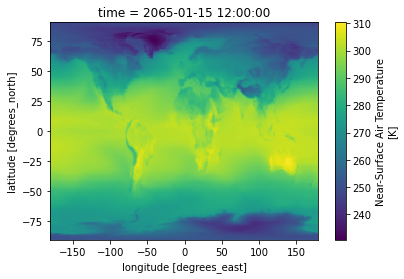

In [16]:
dst_ds.isel(time=0).tas.plot()

Open a dataset to regrid. First, try a monthly file of the same variable as the target:

In [17]:
src_fp = cmip6_dir.joinpath(
    "/beegfs/CMIP6/arctic-cmip6/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/Amon/tas/gn/v20200702/tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc"
)
src_ds = xr.open_dataset(src_fp)

Now regrid:

In [18]:
%%time
regridder = xe.Regridder(src_ds, dst_ds, 'bilinear', unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

CPU times: user 3.08 s, sys: 357 ms, total: 3.44 s
Wall time: 3.58 s


View the results (original on the left):

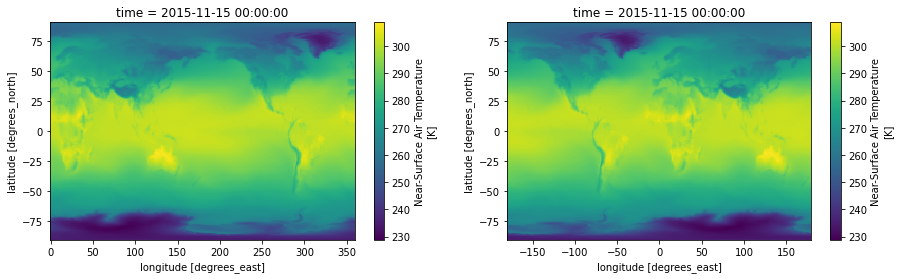

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].isel(time=10).plot(ax=ax[0])
regrid_ds["tas"].isel(time=10).plot(ax=ax[1])

Note, this does cause a line at the prime meridian for some datasets, but that might be the case with the other proposed solution as well.

For example, GFDL-ESM4 does not have data at 0 degrees longitude:

Minimum longitude: 0.625
Maximum longitude: 359.375


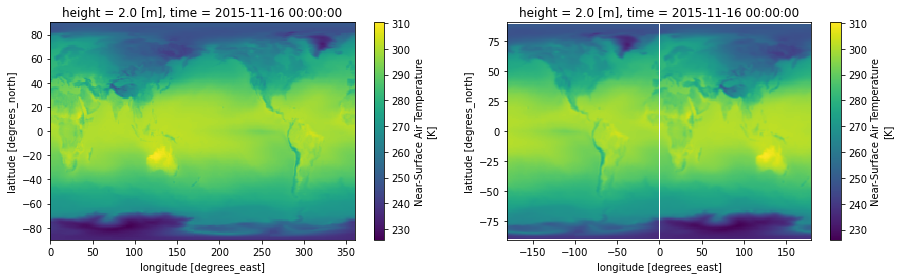

In [20]:
src_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/Amon/tas/gr1/v20180701/tas_Amon_GFDL-ESM4_ssp585_r1i1p1f1_gr1_201501-210012.nc"
)
src_ds = xr.open_dataset(src_fp)
print(f"Minimum longitude: {src_ds.lon.min()}")
print(f"Maximum longitude: {src_ds.lon.max()}")

regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
src_ds["tas"].isel(time=10).plot(ax=ax[0])
regrid_ds["tas"].isel(time=10).plot(ax=ax[1])

In [21]:
src_ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1032)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    height     float64 ...
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes: (12/46)
    external_variables:     areacella
    history:                File was processed by fremetar (GFDL analog of CM...
    table_id:               Amon
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    ...                     ...
    title:                  NOAA GFDL GFDL-ESM4 model output prepared for CMI...
    tracking_id:            hdl:21.14100/b57955a9-7926-4a7e-b5cc-6c65c3c1949f
    variable_id:            tas
    variant_info:           N/A
    references:             see further_info_url attribute
    variant_label:          r1i1p1f1

### Extrapolation?



But if we use the extrapolation option, we can fill those in:

Text(0.5, 0, 'longitude')

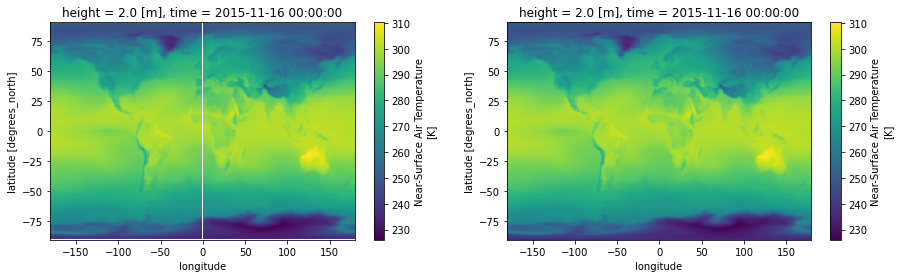

In [23]:
regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True, extrap_method="nearest_s2d")
regrid_x_ds = regridder(src_ds, keep_attrs=True)

regridder = xe.Regridder(src_ds, dst_ds, "bilinear", unmapped_to_nan=True)
regrid_ds = regridder(src_ds, keep_attrs=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
regrid_ds["tas"].isel(time=10).plot(ax=ax[0])
ax[0].set_xlabel("longitude")
regrid_x_ds["tas"].isel(time=10).plot(ax=ax[1])
ax[1].set_xlabel("longitude")


So what would this look like, for all models? How many pixels would we be extrapolating for each?

Define a function to take a model and scenario and figure out what pixels are extrapolated:

In [9]:
def get_extrap_pixel_mask(model):

    # model = "GFDL-ESM4"
    scenario = "ssp585"

    inst = model_inst_lu[model]
    variant = transfers_config.prod_variant_lu[model]

    try:
        src_fp = list(
            cmip6_dir.glob(
                f"ScenarioMIP/{inst}/{model}/{scenario}/{variant}/Amon/tas/*/*/tas_Amon_{model}_{scenario}_{variant}_*.nc"
            )
        )[0]
    except IndexError:
        print(f"No files found for {model}, {scenario}")
        return None

    src_ds = xr.open_dataset(src_fp)

    # we only need the non-extrapolated version, expect all NaNs to be filled
    try:
        regridder = xe.Regridder(
            src_ds["tas"].isel(time=0), dst_ds, "bilinear", unmapped_to_nan=True
        )
        non_extrap_ds = regridder(src_ds["tas"].isel(time=0), keep_attrs=True)
    except KeyError:
        print(f"tas not found in {src_fp}?")
        return None

    return np.isnan(non_extrap_ds)

In [10]:
extrap_masks = {}
for model in transfers_config.prod_variant_lu:
    extrap_masks[model] = get_extrap_pixel_mask(model)

No files found for MRI-ESM2-0, ssp585


In [11]:
# drop empty models (shouldn't be any but there is a bug currently about MRI- model)
extrap_masks = {k: v for k, v in extrap_masks.items() if v is not None}
# now cross compare grids to see if any are equal (we assume the NCAR-based grids would all be the same (CESM2, NorESM, TaiESM1..))
done_sets = []
for m1, m2 in product(extrap_masks.keys(), extrap_masks.keys()):
    if m1 == m2:
        continue
    if {m1, m2} not in done_sets:
        # only need to check if the comparison has not been made
        if np.array_equal(extrap_masks[m1], extrap_masks[m2]):
            print(f"{m1} and {m2} are the same")
            done_sets.append({m1, m2})

CNRM-CM6-1-HR and EC-Earth3-Veg are the same
CNRM-CM6-1-HR and MPI-ESM1-2-HR are the same
EC-Earth3-Veg and MPI-ESM1-2-HR are the same
GFDL-ESM4 and HadGEM3-GC31-LL are the same
GFDL-ESM4 and HadGEM3-GC31-MM are the same
GFDL-ESM4 and KACE-1-0-G are the same
HadGEM3-GC31-LL and HadGEM3-GC31-MM are the same
HadGEM3-GC31-LL and KACE-1-0-G are the same
HadGEM3-GC31-MM and KACE-1-0-G are the same
NorESM2-MM and TaiESM1 are the same
NorESM2-MM and CESM2-WACCM are the same
TaiESM1 and CESM2-WACCM are the same


Okay it looks like we have three different groups here:
1. CNRM-CM6-1-HR, EC-Earth3-Veg, MPI-ESM1-2-HR
2. GFDL-ESM4, HadGEM3-GC31-LL, HadGEM3-GC31-MM, KACE-1-0-G
3. TaiESM1, NorESM2-MM, CESM2-WACCM

The first case appears to only have 1 single extrapolated rows along the top and bottom:

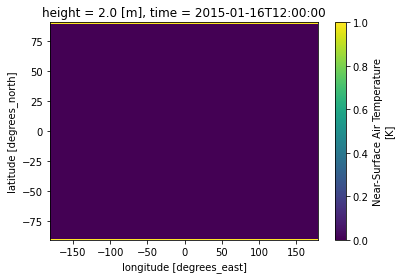

In [12]:
extrap_masks["CNRM-CM6-1-HR"].plot()

The second case has the missing prime meridian:

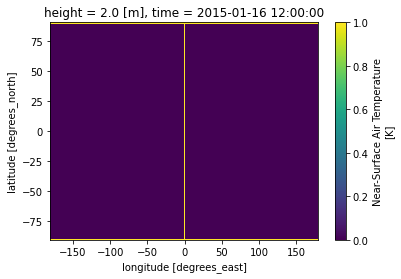

In [13]:
extrap_masks["GFDL-ESM4"].plot()

And the third case of course has no extrapolations:

In [14]:
assert np.all(~extrap_masks["TaiESM1"])

With this information, it is probably safe to simply have a note for our datasets that the northernmost row of pixels (288 total) were extrapolated for CNRM-CM6-1-HR, EC-Earth3-Veg, and MPI-ESM1-2-HR, and those along the prime meridian were additionally extrapolated for GFDL-ESM4, HadGEM3-GC31-LL, HadGEM3-GC31-MM, and KACE-1-0-G (this will end up being 42 pixels after cropping to the panarctic). 

### Test regridding object re-use

Now ensure that we can use the same regridding object on a file with a different number of time steps (e.g. a daily file) but with the same grid. This will help us be more efficient. According to the docs, [this should be acceptable](https://xesmf.readthedocs.io/en/latest/notebooks/Reuse_regridder.html).

In [15]:
daily_src_fp = cmip6_dir.joinpath(
    "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp585/r1i1p1f1/day/tas/gr1/v20180701/tas_day_GFDL-ESM4_ssp585_r1i1p1f1_gr1_20150101-20341231.nc"
)
daily_src_ds = xr.open_dataset(daily_src_fp)

Regrid:

In [16]:
%%time
daily_regrid_ds = regridder(daily_src_ds, keep_attrs=True)

CPU times: user 8.6 s, sys: 2.6 s, total: 11.2 s
Wall time: 12.3 s


Plot results:

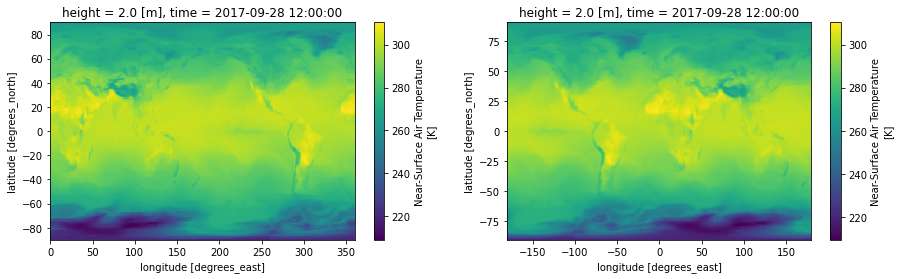

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
daily_src_ds["tas"].isel(time=1000).plot(ax=ax[0])
daily_regrid_ds["tas"].isel(time=1000).plot(ax=ax[1])

Plot the time series at a single point to make sure the broadcasting is correct (top is original):

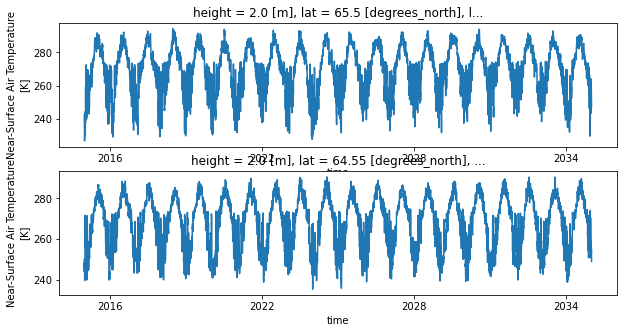

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
test_lon = 180 + (180 - 148)  # lon domain is approx (0, 360)
test_lat = 65
daily_src_ds["tas"].sel(lat=test_lat, lon=test_lon, method="nearest").plot(ax=ax[0])
daily_regrid_ds["tas"].sel(lat=test_lat, lon=test_lon, method="nearest").plot(ax=ax[1])

Great. So we can use an established `regridder` object with weights to regrid multiple files, provided they have the same grid. Also, note that regridding the daily file took approximately 30s.

## Optimizing for multiple files

This section will be used to determine a reasonable number of files to regrid in a single `sbatch` job. We will attempt to regrid a handful of daily files using `dask.delayed`, and compare.

In [11]:
import dask

Choose some daily temperature files to regrid. There should be 20 in this glob:

In [20]:
src_fps = list(
    cmip6_dir.glob(
        "ScenarioMIP/NOAA-GFDL/GFDL-ESM4/*/r1i1p1f1/day/tas/gr1/v20180701/*.nc"
    )
)
len(src_fps)

20

Define a function to regrid and write a file:

In [26]:
@dask.delayed
def regrid_file(fp, regridder, out_fp):
    src_ds = xr.open_dataset(fp)
    regrid_ds = regridder(src_ds)
    regrid_ds.to_netcdf(out_fp)

    return out_fp

Make and output dir:

In [27]:
out_dir = SCRATCH_DIR.joinpath("regrid_testing")
out_dir.mkdir(exist_ok=True)

Create the regridder object:

In [ ]:
daily_regrid_ds = regridder(daily_src_ds, keep_attrs=True)

Run the regridding:

In [30]:
results = []
for fp in src_fps:
    out_fp = out_dir.joinpath(fp.name.replace(".nc", "_regrid.nc"))
    results.append(regrid_file(fp, regridder, out_fp))

In [31]:
%%time
dask.compute(results)

CPU times: user 6min 37s, sys: 5min 27s, total: 12min 5s
Wall time: 6min 34s


([PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20350101-20541231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20750101-20941231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20550101-20741231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20950101-21001231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp245_r1i1p1f1_gr1_20150101-20341231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp370_r1i1p1f1_gr1_20350101-20541231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredilla/cmip6_regridding/regrid_testing/tas_day_GFDL-ESM4_ssp370_r1i1p1f1_gr1_20750101-20941231_regrid.nc'),
  PosixPath('/center1/SNAP/kmredil

Okay this seems like an efficient and simple way to move forward. If we can process 20 daily files in under 6 minutes, we should be safe with only trying to process ~200 files in under the two hours. This should inform our generation of batch files, with each batch file containing at most 200 hundred files. 